# Tema 4:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import Lambda

## 1. Guardar y cargar modelos.

### 1.1. Entrenar 5 épocas un MLP (utilizar el de la sesión 2) con el dataset MNIST.

Vamos a entrenar un MLP con Mnist y guardar el modelo en un fichero.

⚠️ Recordar trabajar con GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Redimensionar imágenes

    transforms.ToTensor(),  # Convertir a tensor
    Lambda(lambda x: x / 255.0)  # Normalización

])

In [ ]:
full_train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 66.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 48.1MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 73.2MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_size = int(0.8 * len(full_train_dataset))  # 80% para entrenamiento
val_size = len(full_train_dataset) - train_size  # 20% para validación


In [ ]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [ ]:
train_dataset, val_dataset

(<torch.utils.data.dataset.Subset at 0x7bf345dd6b30>,
 <torch.utils.data.dataset.Subset at 0x7bf345dd4d00>)

In [ ]:
def flatten_batch(data):

    images_collate = torch.stack([item[0] for item in data])
    labels_collate = torch.tensor([item[1] for item in data])

    # Aplanar las imágenes (batch_size, 28*28)
    images = images_collate.view(images_collate.size(0), -1)
    return images, labels_collate

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=flatten_batch)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=flatten_batch)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=flatten_batch)

In [ ]:
class MLP_pytorch(nn.Module):
    def __init__(self, input_shape=150*150, n_classes=10):
        super().__init__()
        self.input_shape = input_shape
        self.n_classes = n_classes


        self.l1 = nn.Linear(self.input_shape, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, self.n_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        # Forward pass
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        return x


In [ ]:
model = MLP_pytorch().to(device)


In [ ]:
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

Época 1/5 | Train Loss: 0.7479, Train Acc: 0.78% | Val Loss: 0.3773, Val Acc: 0.89%
Época 2/5 | Train Loss: 0.3304, Train Acc: 0.90% | Val Loss: 0.2985, Val Acc: 0.91%
Época 3/5 | Train Loss: 0.2731, Train Acc: 0.92% | Val Loss: 0.2572, Val Acc: 0.92%
Época 4/5 | Train Loss: 0.2373, Train Acc: 0.93% | Val Loss: 0.2335, Val Acc: 0.93%
Época 5/5 | Train Loss: 0.2102, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%


### 1.2. Guardamos el modelo.
Se recomienda guardar el estado de los parámetros del modelo (state_dict) en lugar de guardar el modelo completo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Guardar los pesos del modelo

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/model.pth")

#### Guardar el modelo completo, estructura + pesos.

In [ ]:
torch.save(model, "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/model_completo.pth")

####Guardar el optimizador

Esto permitirá continuar el entrenamiento a partir del mismo punto

In [ ]:
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/"
filename = f"{path}checkpoint_epoch_{epoch}.pth"

torch.save({
    'epoch': epoch,  # Número de épocas completadas
    'model_state_dict': model.state_dict(),  # Estado del modelo
    'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
    'loss': loss  # Última pérdida registrada (opcional)
}, f"{filename}")


### 1.3. Cargamos el modelo.

#### Cargar pesos del modelo.

1. Crear un modelo
2. Cargar los pesos

In [ ]:
model_2 = MLP_pytorch()

In [ ]:
model_2.load_state_dict(torch.load("/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/model.pth"))

<ipython-input-19-440efe0753cc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load("/content/drive/My Drive/Trabajo/Docencia/curso_24_25/tit

<All keys matched successfully>

#### Cargar el modelo completo

In [ ]:
model_complete = torch.load("/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/model_completo.pth")

<ipython-input-20-b5df35f083a3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_complete = torch.load("/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_pro

Cargamos el optimizador.

Cuando cargues el modelo en otra sesión, asegúrate de inicializar la misma arquitectura y el optimizador antes de cargar los datos guardados.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Usa el mismo optimizador

# Cargar el checkpoint
checkpoint = torch.load(filename)
model_complete.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Mover a GPU si es necesario
model = model_complete.to('cuda' if torch.cuda.is_available() else 'cpu')


<ipython-input-21-36a3718c9f47>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
epochs = 5

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Época 1/5 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
Época 2/5 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
Época 3/5 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
Época 4/5 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
Época 5/5 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%


## 2. Evaluación del modelo y visualización de métricas

### 2.1. Evaluar el modelo

In [ ]:
model.eval()

# Evaluación del modelo
total_loss = 0.0
correct = 0
total = 0
criterion = torch.nn.CrossEntropyLoss()  # Asegúrate de usar el mismo criterio que durante el entrenamiento

with torch.no_grad():  # No calcular gradientes
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU si está disponible

        # Adelante
        outputs = model(inputs.view(inputs.size(0), -1))  # Aplanar si usas una MLP
        loss = criterion(outputs, labels)

        # Acumular la pérdida
        total_loss += loss.item()

        # Calcular predicciones correctas
        _, predicted = torch.max(outputs, 1)  # Clase con mayor probabilidad
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Cálculo de métricas
avg_loss = total_loss / len(test_loader)
accuracy = correct / total

print(f"Pérdida promedio en test: {avg_loss:.4f}")
print(f"Precisión en test: {accuracy:.4%}")

Pérdida promedio en test: 0.2010
Precisión en test: 93.7800%


In [ ]:
image_shape = (150, 150)

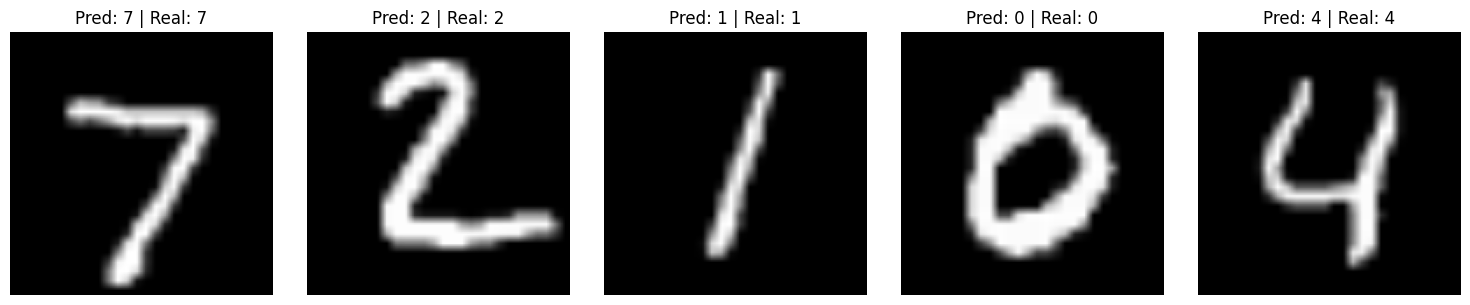

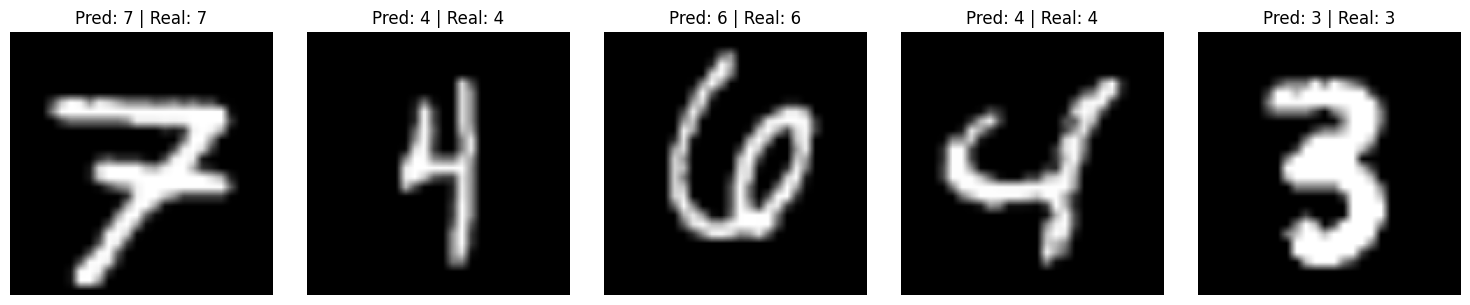

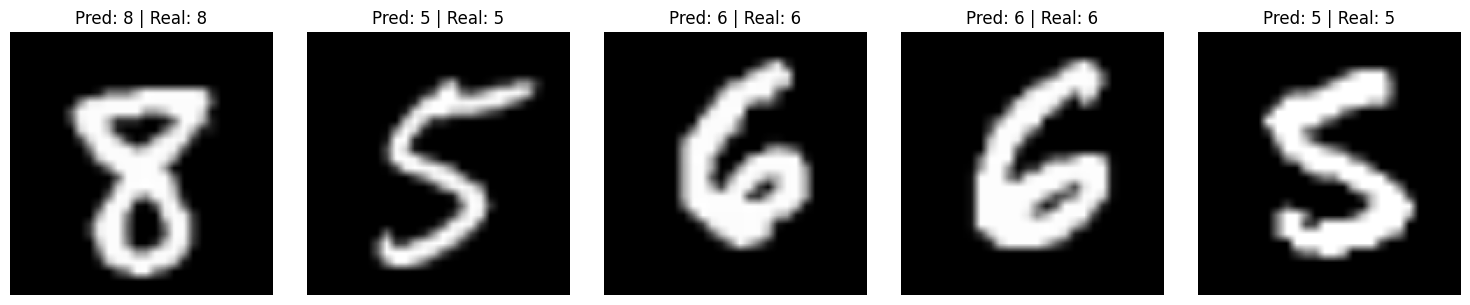

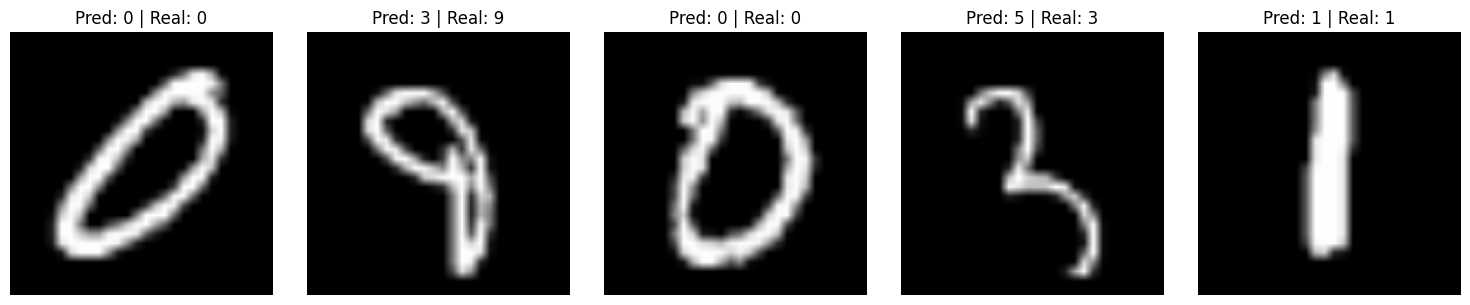

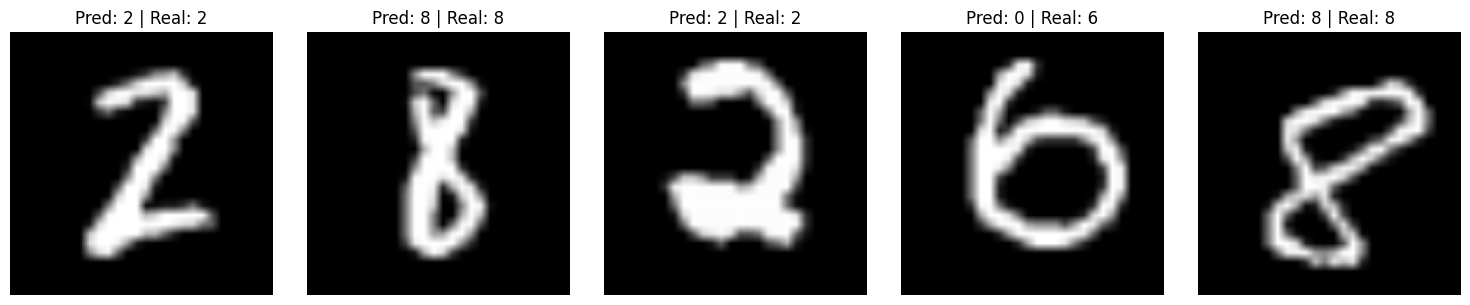

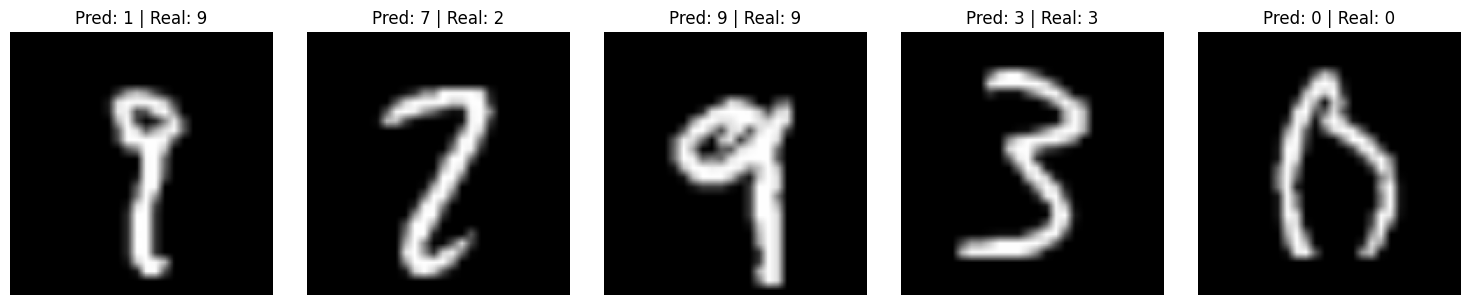

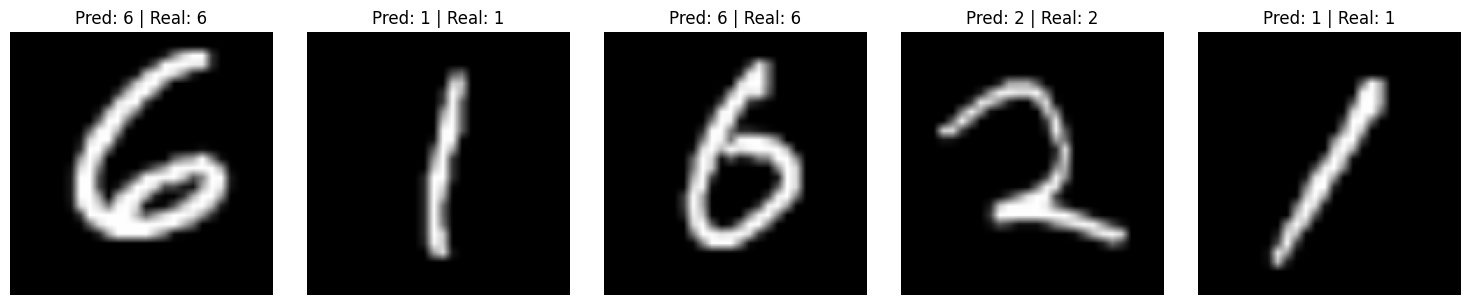

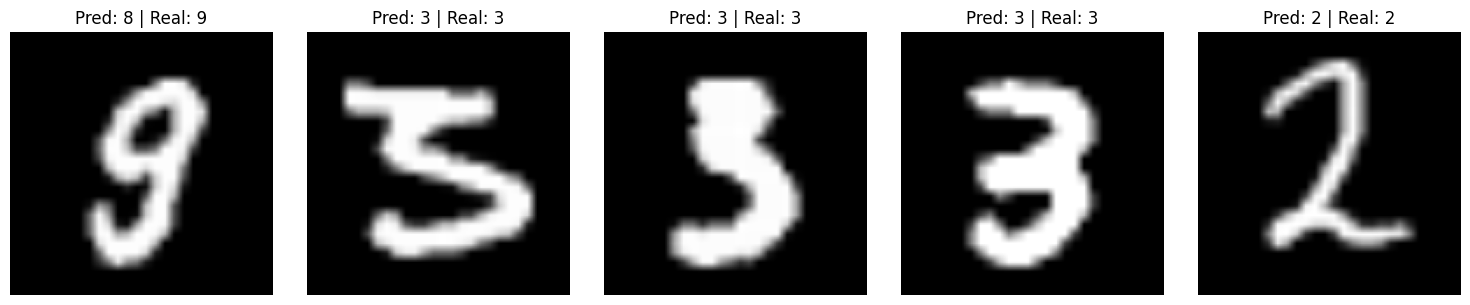

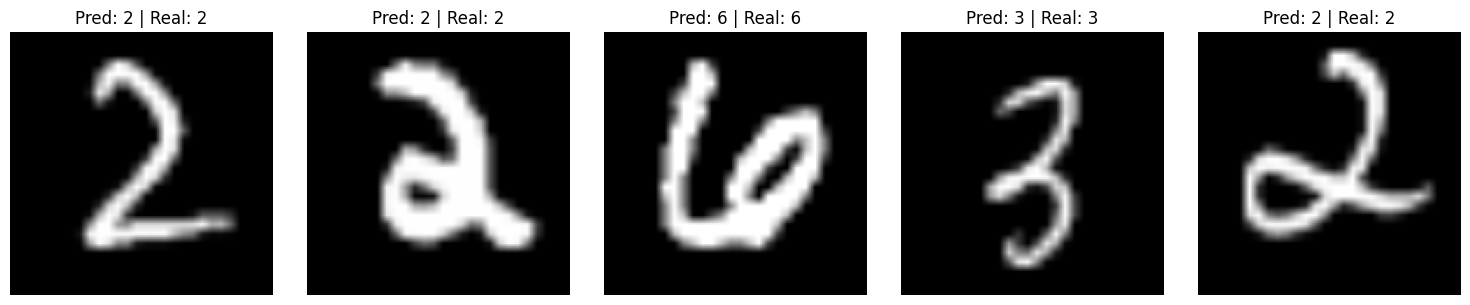

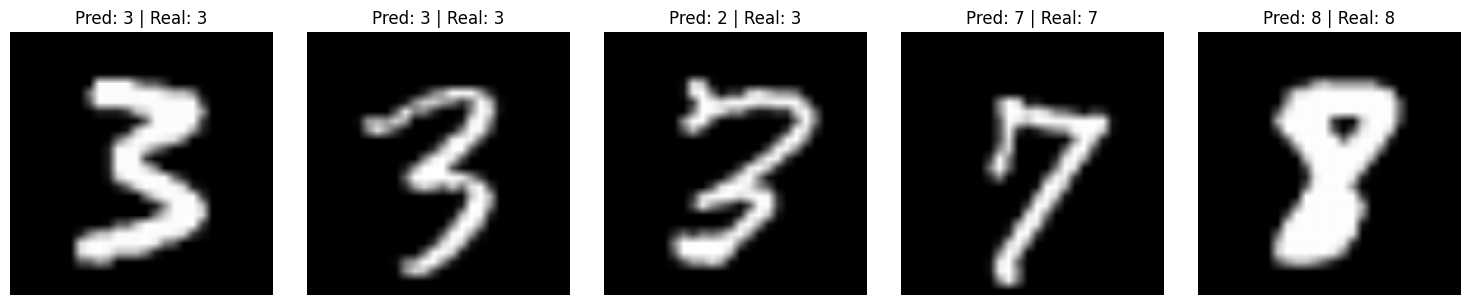

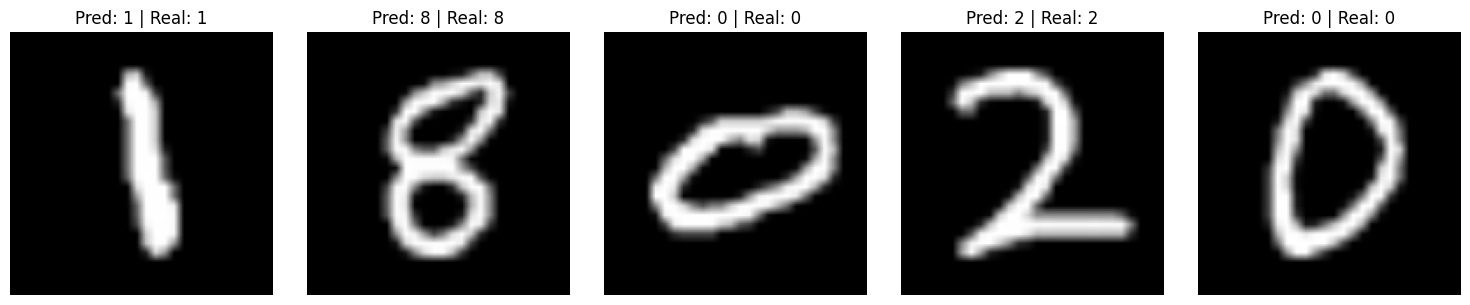

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():  # No calcular gradientes
    for j, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU si está disponible

        # Adelante
        outputs = model(inputs)  # No es necesario volver a aplanar si ya están aplanadas
        loss = criterion(outputs, labels)

        # Acumular la pérdida
        total_loss += loss.item()

        # Calcular predicciones correctas
        _, predicted = torch.max(outputs, 1)  # Clase con mayor probabilidad
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Mostrar 5 imágenes en una única visualización
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Crear figura con 5 subgráficos en línea
        for i, (img, pred, target) in enumerate(zip(inputs, predicted, labels)):
            if i >= 5:  # Limitar a 5 imágenes por iteración
                break

            # Restaurar la forma original de la imagen (batch_size, 28, 28)
            img = img.view(image_shape).cpu()  # Cambiar la forma y mover a CPU

            # Mostrar imagen en el subgráfico correspondiente
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Pred: {pred.item()} | Real: {target.item()}")
            axes[i].axis('off')  # Ocultar ejes para mejor visualización

        # Mostrar toda la figura
        plt.tight_layout()  # Ajustar espaciado
        plt.show()
        if j == 10:
          break


### 2.2. Visaulización de métricas

#### Evaluamos el modelo guardando:


*   Etiquetas reales
*   Predicciones
*   Probabilidades

Visualizaciones:
*   Reporte de la clasificación: devolverá la precisión, recall y el F1-score.
*   Matriz de confusión
*   Curva ROC por clases




In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cambiar el modelo a modo evaluación
model.eval()

# Acumular etiquetas reales, predicciones y probabilidades
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Adelante
        outputs = model(inputs.view(inputs.size(0), -1))  # Aplanar si es necesario
        probabilities = torch.softmax(outputs, dim=1)  # Obtener probabilidades
        _, predicted = torch.max(outputs, 1)  # Predicciones de clase

        # Acumular resultados
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convertir a NumPy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

#### **Reporte de clasificación**

In [ ]:
print("Reporte de Clasificación:\n")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

Reporte de Clasificación:

              precision    recall  f1-score   support

    0 - zero       0.94      0.98      0.96       980
     1 - one       0.96      0.99      0.97      1135
     2 - two       0.94      0.93      0.94      1032
   3 - three       0.90      0.94      0.92      1010
    4 - four       0.93      0.95      0.94       982
    5 - five       0.93      0.87      0.90       892
     6 - six       0.95      0.95      0.95       958
   7 - seven       0.96      0.94      0.95      1028
   8 - eight       0.94      0.88      0.91       974
    9 - nine       0.93      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



#### **Matriz de confusión**

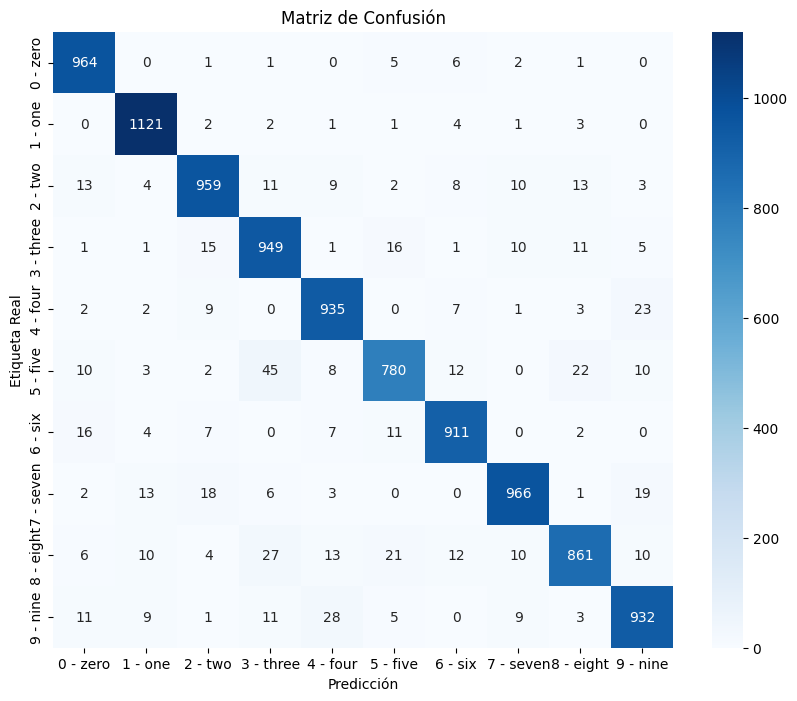

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

#### **Curva ROC por clases**

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
classes = np.unique(all_labels)
y_true_bin = label_binarize(all_labels, classes=classes)


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC macro promedio
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), all_probabilities.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

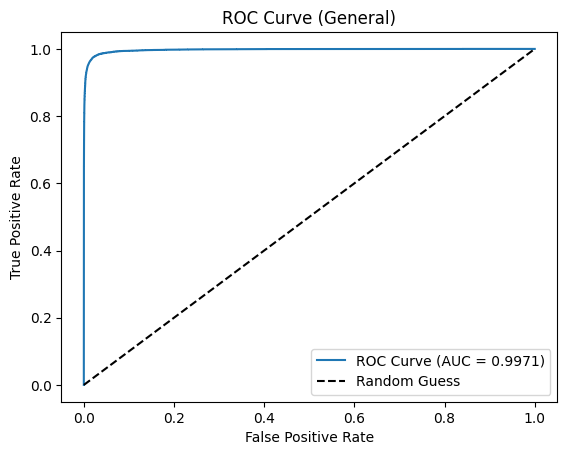

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label=f'ROC Curve (AUC = {roc_auc["macro"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (General)')
plt.legend(loc="lower right")
plt.show()

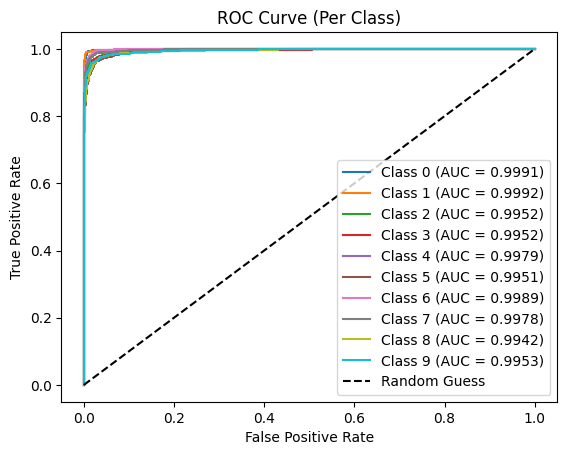

In [ ]:
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Per Class)')
plt.legend(loc="lower right")
plt.show()

## 3. Precisión mixta automática

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
batch_size = 256
input_size = 784  # Tamaño de entrada
hidden_size = 128
output_size = 10

In [3]:
X = torch.randn(1000000, input_size).to(device)
y = torch.randint(0, output_size, (1000000,)).to(device)
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [4]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [5]:
def measure_memory_and_time(train_fn, name):
    torch.cuda.empty_cache()  # Limpia caché antes de iniciar
    torch.cuda.synchronize()  # Sincroniza GPU
    start_time = time.time()
    start_reserved = torch.cuda.memory_reserved(device) / 1e6  # En MB
    train_fn()
    torch.cuda.synchronize()  # Sincroniza GPU nuevamente
    end_time = time.time()
    end_reserved = torch.cuda.memory_reserved(device) / 1e6  # En MB
    #print(f"{name} completado en {end_time - start_time:.2f} segundos")
    print(f"Memoria reservada utilizada: {end_reserved - start_reserved:.2f} MB\n")


In [6]:
def train_standard():
    model = SimpleModel().to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()


In [7]:
def train_amp():
    model = SimpleModel().to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()  # Escalador para gradientes

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            with autocast(device_type="cuda"):  # Habilita precisión mixta
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
            scaler.scale(loss).backward()  # Escala los gradientes
            scaler.step(optimizer)  # Actualiza los pesos
            scaler.update()  # Ajusta el escalador

In [10]:
if device == "cuda":
    print("Medición sin AMP...")
    measure_memory_and_time(train_standard, "Entrenamiento estándar")

    print("Medición con AMP...")
    measure_memory_and_time(train_amp, "Entrenamiento con AMP")
else:
    print("AMP solo es aplicable en GPU.")


Medición sin AMP...
Memoria reservada utilizada: 27.26 MB

Medición con AMP...
Memoria reservada utilizada: 6.29 MB



## 4. Handlers en pytorch

### Early Stopping

Es una técnica utilizada durante el entrenamiento de modelos para **detener el proceso** de entrenamiento **automáticamente** si una métrica monitorizada deja de mejorar después de un número especificado de épocas.


In [ ]:
patience = 3
min_delta = 0.005
best_val_loss = float('inf')
early_stop_counter = 0

epochs = 50
val_loss_history = []

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- Early Stopping ---
    if epoch >= 1:
      improvement = val_loss_history[-2] - val_loss_history[-1]
      if improvement > min_delta:
          best_val_loss = val_loss  # Actualiza la mejor pérdida de validación
          early_stop_counter = 0  # Reinicia el contador
          print(f"Mejora significativa en pérdida de validación: {improvement:.4f}")
      else:
          early_stop_counter += 1  # Incrementa el contador si no mejora
          print(f"No mejora suficiente en la pérdida de validación por {early_stop_counter} época(s).")

      if early_stop_counter >= patience:
          print("Activado Early Stopping: no hay mejora suficiente en la pérdida de validación.")
          break  # Detiene el entrenamiento


Época 1/50 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
Época 2/50 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
No mejora suficiente en la pérdida de validación por 1 época(s).
Época 3/50 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
No mejora suficiente en la pérdida de validación por 2 época(s).
Época 4/50 | Train Loss: 0.1921, Train Acc: 0.94% | Val Loss: 0.2068, Val Acc: 0.94%
No mejora suficiente en la pérdida de validación por 3 época(s).
Activado Early Stopping: no hay mejora suficiente en la pérdida de validación.


### Model Checkpoint

Herramienta que permite guardar automáticamente los mejores modelos durante el entrenamiento basándose en una métrica específica. También se puede usar para guardar checkpoints periódicamente.

In [ ]:
best_val_loss = float('inf')
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/"
checkpoint_namefile = "best_model.pth"

model = MLP_pytorch().to(device)
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_path = path+checkpoint_namefile

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- ModelCheckpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Actualiza la mejor pérdida de validación
        torch.save(model.state_dict(), checkpoint_path)  # Guarda el modelo
        print(f"Modelo guardado en {checkpoint_path} con pérdida de validación: {best_val_loss:.4f}")


Época 1/5 | Train Loss: 0.6945, Train Acc: 0.80% | Val Loss: 0.3452, Val Acc: 0.90%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.3452
Época 2/5 | Train Loss: 0.3102, Train Acc: 0.91% | Val Loss: 0.2830, Val Acc: 0.92%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.2830
Época 3/5 | Train Loss: 0.2614, Train Acc: 0.92% | Val Loss: 0.2557, Val Acc: 0.92%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.2557
Época 4/5 | Train Loss: 0.2243, Train Acc: 0.93% | Val Loss: 0.2158, Val Acc: 0.93%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.2158
Época 5/5 | Train Loss: 0.1938, Train Acc: 0.94% | Val Loss: 0.1982, Val Acc: 0.94%
Mode

In [ ]:
best_val_loss = float('inf')
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/"
plot_namefile = "training_plot"

model = MLP_pytorch().to(device)
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
plot_path = path+plot_namefile

In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
best_val_loss = float('inf')
best_epoch = 0

Época 1/5 | Train Loss: 0.6806, Train Acc: 0.80% | Val Loss: 0.3489, Val Acc: 0.90%


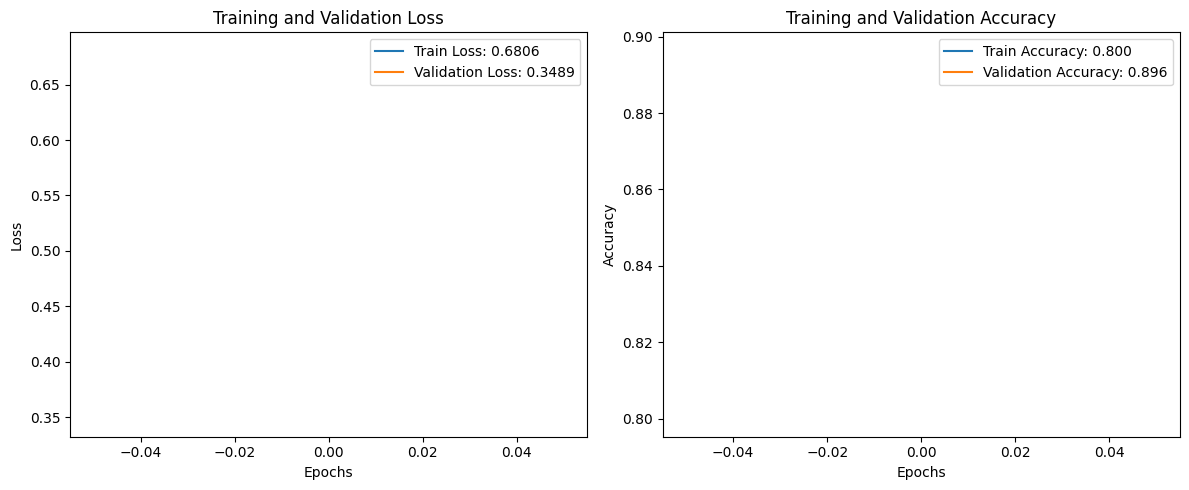

Época 2/5 | Train Loss: 0.3061, Train Acc: 0.91% | Val Loss: 0.2756, Val Acc: 0.92%


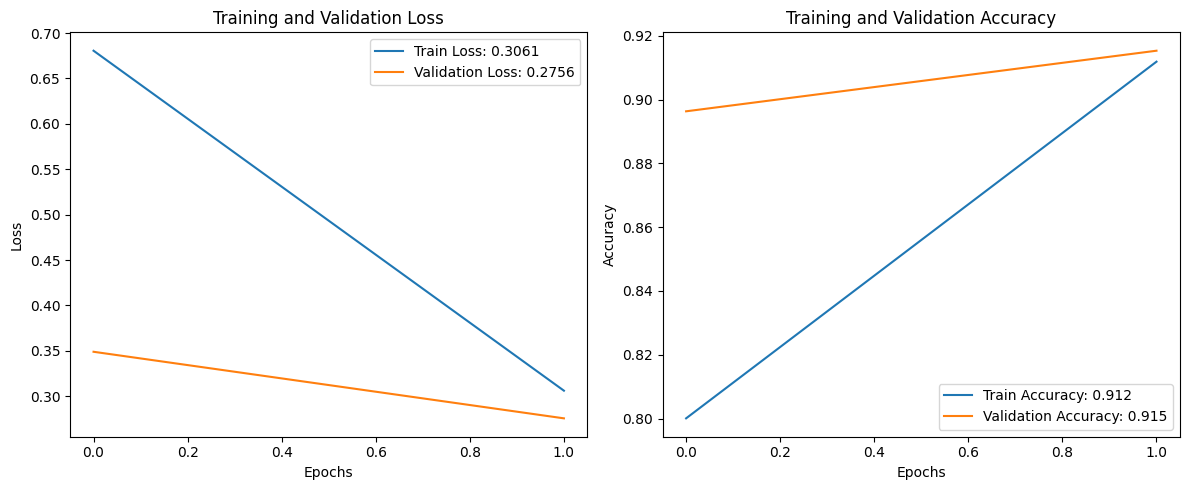

Época 3/5 | Train Loss: 0.2548, Train Acc: 0.93% | Val Loss: 0.2394, Val Acc: 0.93%


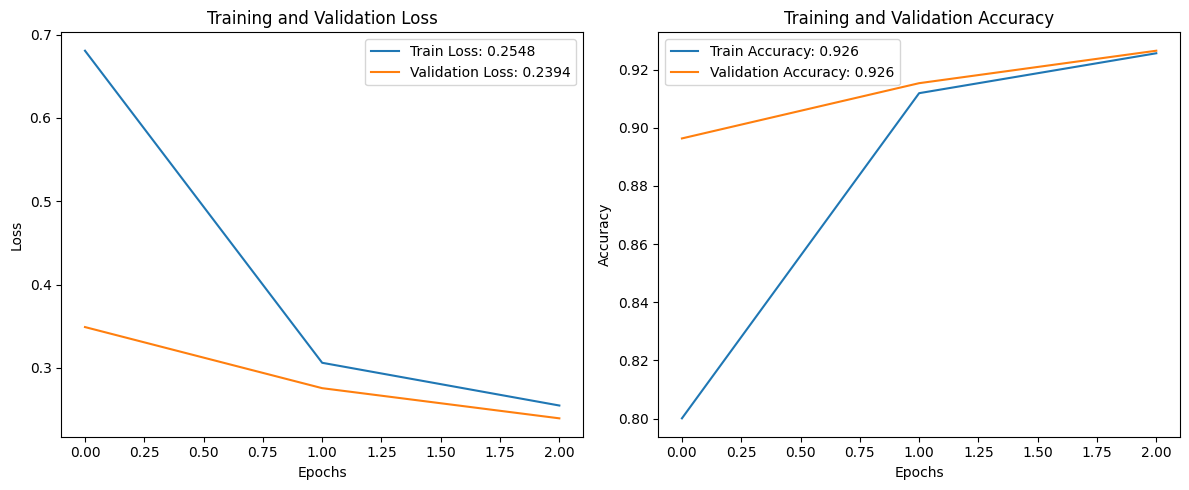

Época 4/5 | Train Loss: 0.2193, Train Acc: 0.94% | Val Loss: 0.2114, Val Acc: 0.93%


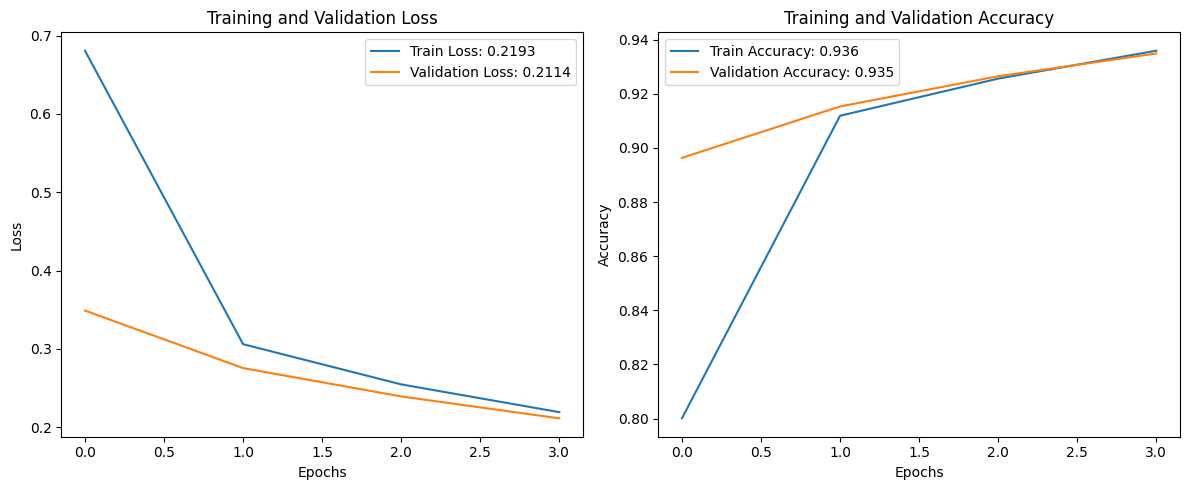

Época 5/5 | Train Loss: 0.1926, Train Acc: 0.94% | Val Loss: 0.2002, Val Acc: 0.94%


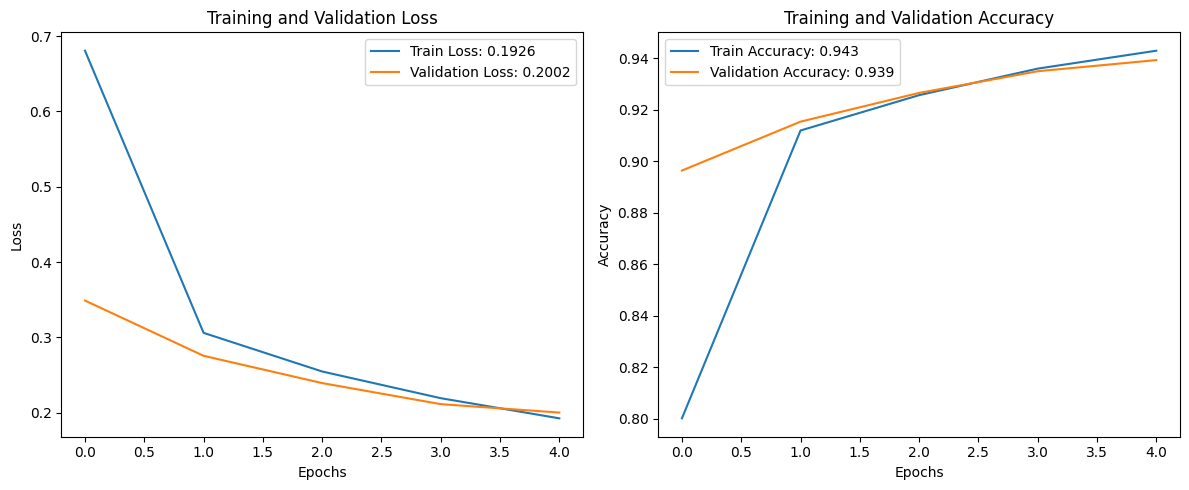

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


    # Crear la visualización nuevamente
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    epochs_ = list(range(len(train_loss_history)))

    # Plot 1: Loss
    axes[0].plot(epochs_, train_loss_history, label=f'Train Loss: {train_loss_history[-1]:.4f}', marker='')
    axes[0].plot(epochs_, val_loss_history, label=f'Validation Loss: {val_loss_history[-1]:.4f}', marker='')
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot 2: Accuracy
    axes[1].plot(epochs_, train_acc_history, label=f'Train Accuracy: {train_acc_history[-1]:.3f}', marker='')
    axes[1].plot(epochs_, val_acc_history, label=f'Validation Accuracy: {val_acc_history[-1]:.3f}', marker='')
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # Ajustar el diseño y guardar como PDF
    plt.tight_layout()
    plt.savefig(plot_path + '.pdf', format="pdf")
    plt.show()






### Guardar métricas en CSV

In [ ]:
import pandas as pd

In [ ]:
model = MLP_pytorch().to(device)
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

csv_file = "training_results.csv"
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/"
csv_path = path+csv_file

header = "epoch,train_loss,train_acc,val_loss,val_acc\n"
with open(csv_path, mode='a') as file:
  file.write(header)

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

    data = f"{epoch},{train_loss},{train_acc},{val_loss},{val_acc}\n"
    with open(csv_path, mode='a') as file:
      file.write(data)



Época 1/5 | Train Loss: 0.6854, Train Acc: 0.80 | Val Loss: 0.3530, Val Acc: 0.89
Época 2/5 | Train Loss: 0.3152, Train Acc: 0.91 | Val Loss: 0.2903, Val Acc: 0.91
Época 3/5 | Train Loss: 0.2592, Train Acc: 0.93 | Val Loss: 0.2459, Val Acc: 0.93
Época 4/5 | Train Loss: 0.2241, Train Acc: 0.93 | Val Loss: 0.2194, Val Acc: 0.93
Época 5/5 | Train Loss: 0.1968, Train Acc: 0.94 | Val Loss: 0.1947, Val Acc: 0.94


In [ ]:
model = MLP_pytorch().to(device)
epochs = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# EarlyStopping
val_loss_history = []
patience = 3
min_delta = 0.005
early_stop_counter = 0

epochs = 50

path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/"
checkpoint_namefile = "best_model.pth"
checkpoint_path = path+checkpoint_namefile

plot_namefile = "training_plot"
plot_path = path+plot_namefile
train_loss_history = []
train_acc_history = []
val_acc_history = []
best_epoch = 0


# Save results as csv
csv_file = "training_results.csv"
csv_path = path+csv_file
header = "epoch,train_loss,train_acc,val_loss,val_acc\n"

with open(csv_path, mode='a') as file:
  file.write(header)


Época 1/50 | Train Loss: 0.6828, Train Acc: 0.81% | Val Loss: 0.3431, Val Acc: 0.89%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.3431


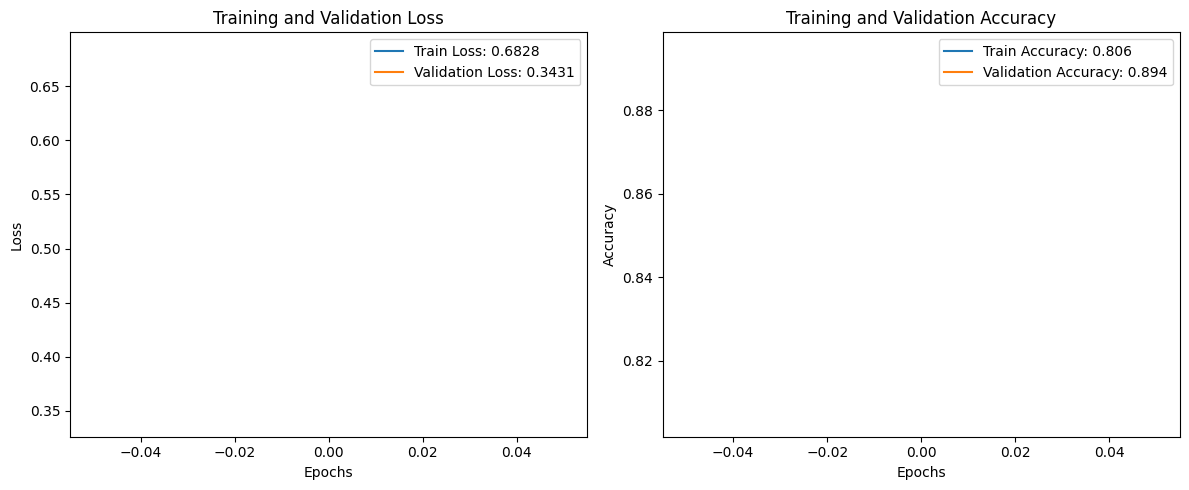

Época 2/50 | Train Loss: 0.3000, Train Acc: 0.91% | Val Loss: 0.2636, Val Acc: 0.92%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.2636


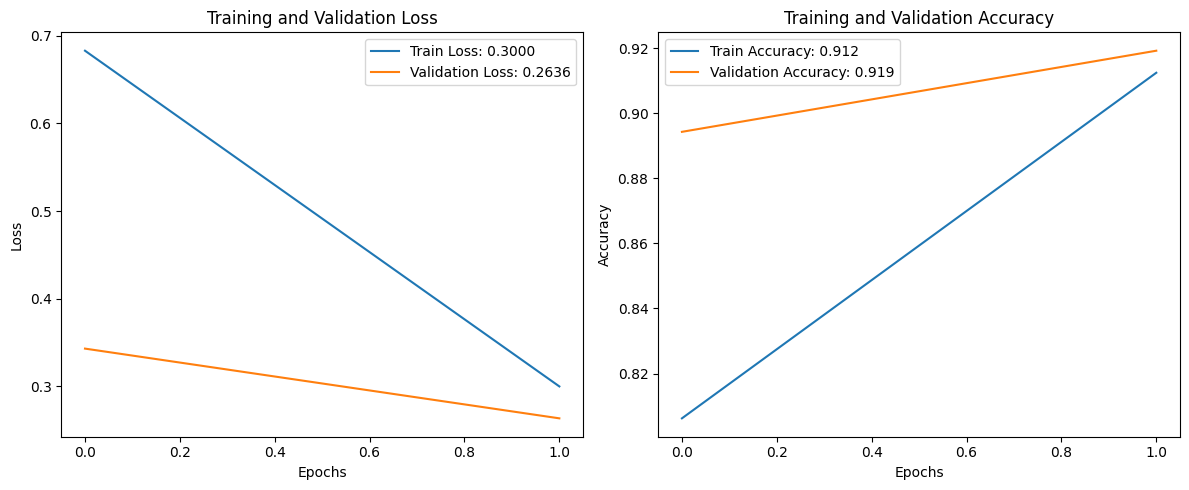

Mejora significativa en pérdida de validación: 0.0795
Época 3/50 | Train Loss: 0.2332, Train Acc: 0.93% | Val Loss: 0.2202, Val Acc: 0.94%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.2202


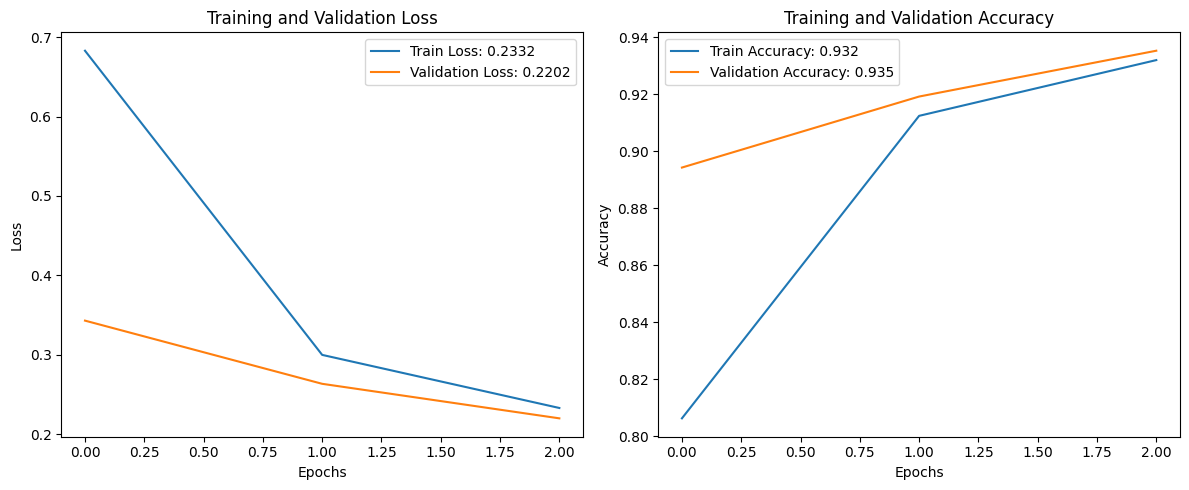

Mejora significativa en pérdida de validación: 0.0435
Época 4/50 | Train Loss: 0.2010, Train Acc: 0.94% | Val Loss: 0.1979, Val Acc: 0.94%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1979


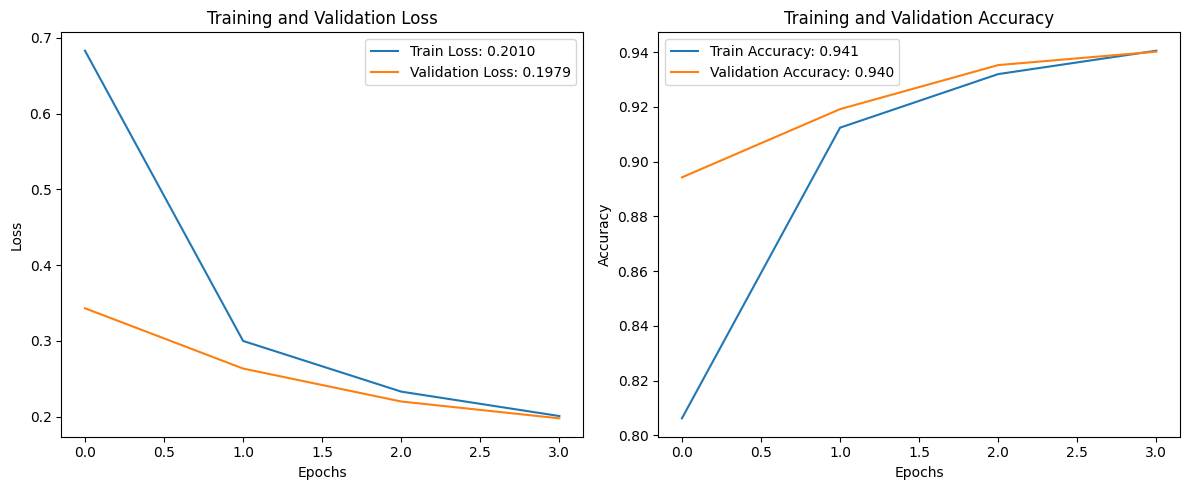

Mejora significativa en pérdida de validación: 0.0222
Época 5/50 | Train Loss: 0.1782, Train Acc: 0.95% | Val Loss: 0.1858, Val Acc: 0.94%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1858


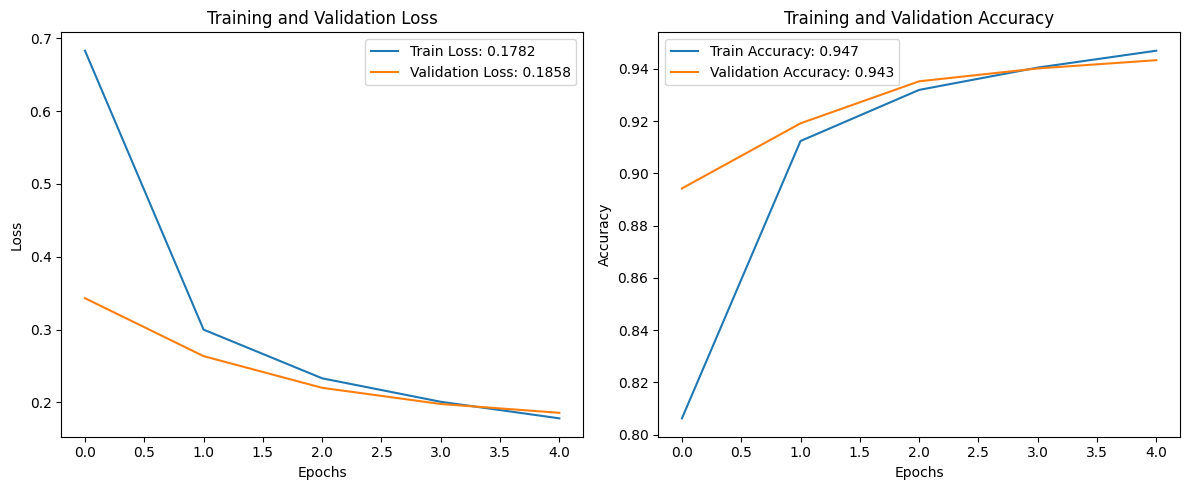

Mejora significativa en pérdida de validación: 0.0121
Época 6/50 | Train Loss: 0.1616, Train Acc: 0.95% | Val Loss: 0.1746, Val Acc: 0.95%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1746


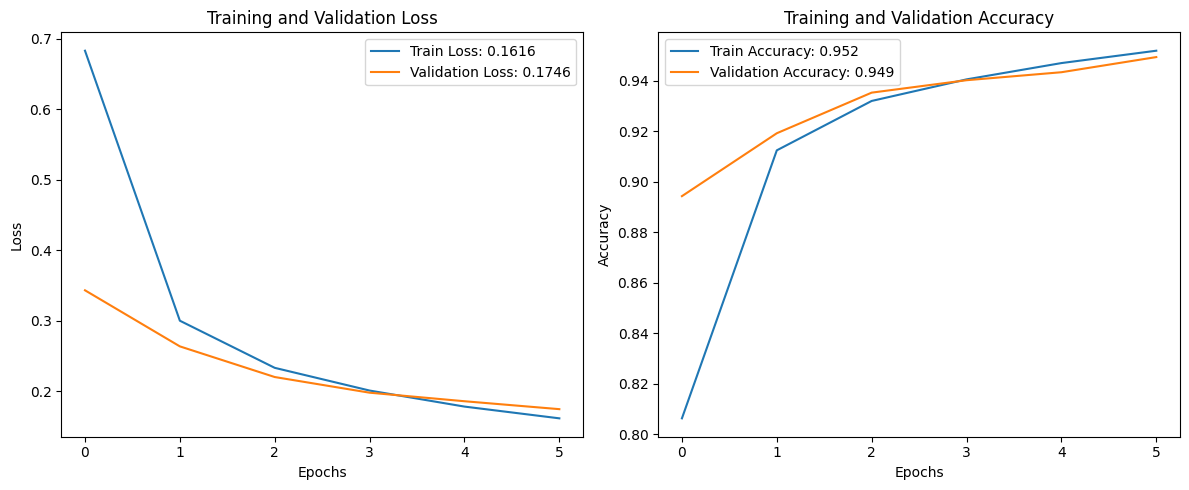

Mejora significativa en pérdida de validación: 0.0112
Época 7/50 | Train Loss: 0.1473, Train Acc: 0.96% | Val Loss: 0.1610, Val Acc: 0.95%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1610


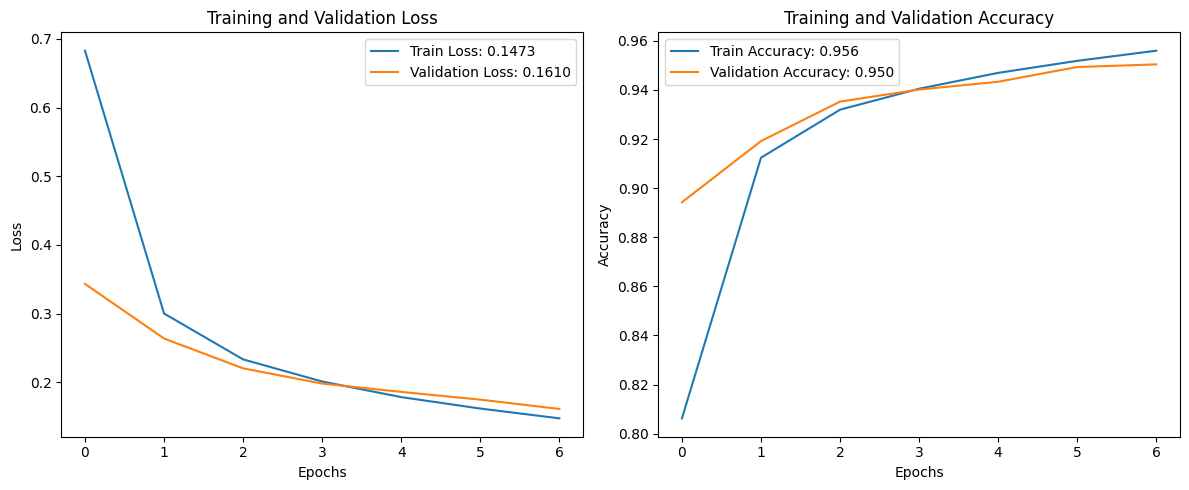

Mejora significativa en pérdida de validación: 0.0136
Época 8/50 | Train Loss: 0.1352, Train Acc: 0.96% | Val Loss: 0.1582, Val Acc: 0.95%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1582


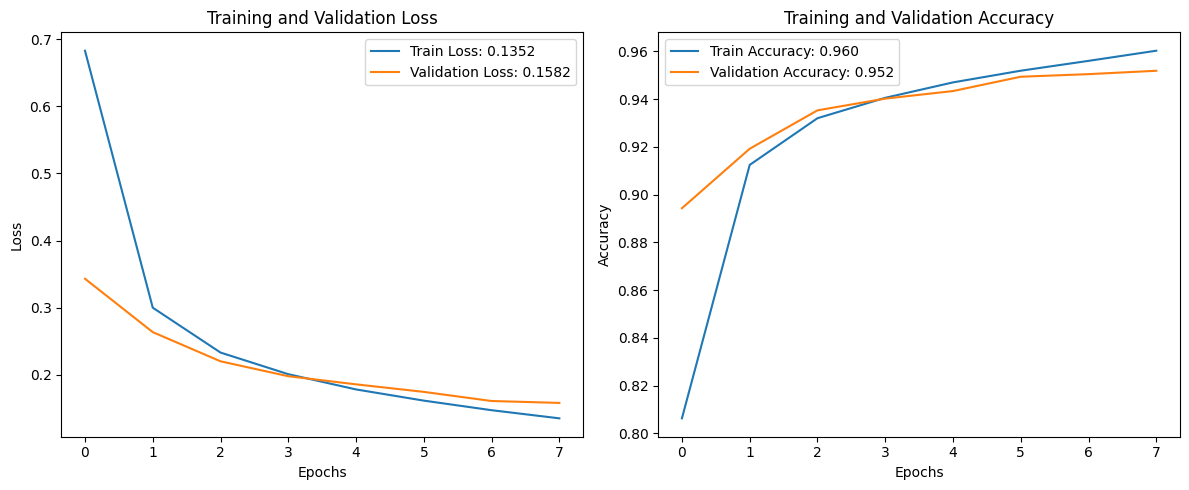

No mejora suficiente en la pérdida de validación por 1 época(s).
Época 9/50 | Train Loss: 0.1250, Train Acc: 0.96% | Val Loss: 0.1466, Val Acc: 0.95%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1466


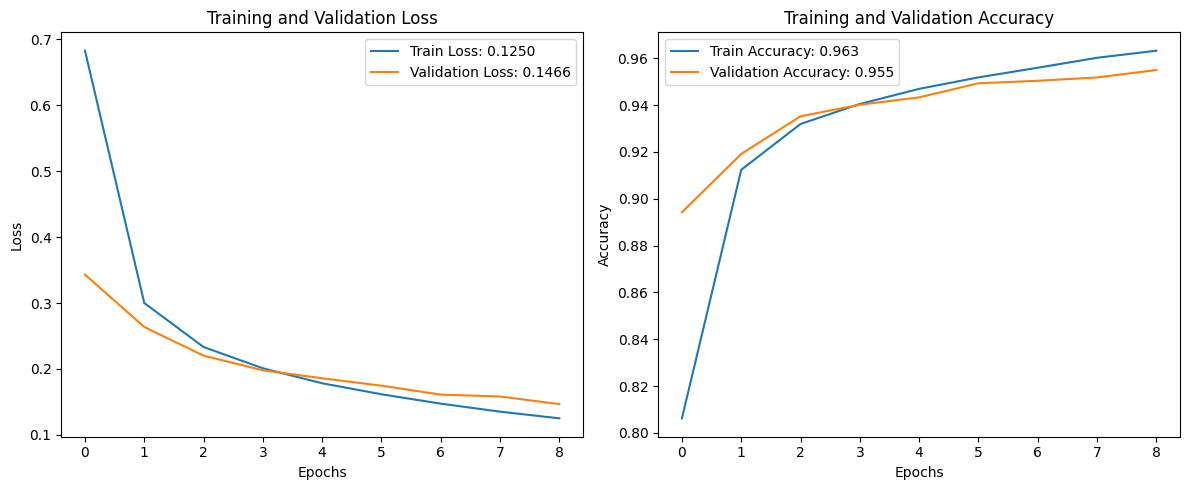

Mejora significativa en pérdida de validación: 0.0116
Época 10/50 | Train Loss: 0.1159, Train Acc: 0.97% | Val Loss: 0.1382, Val Acc: 0.96%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1382


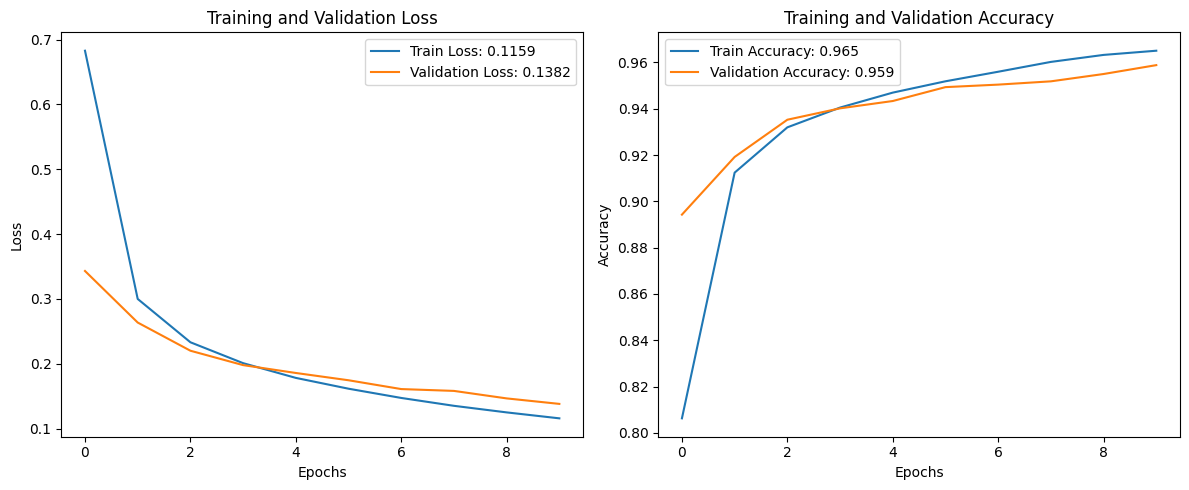

Mejora significativa en pérdida de validación: 0.0085
Época 11/50 | Train Loss: 0.1075, Train Acc: 0.97% | Val Loss: 0.1387, Val Acc: 0.96%


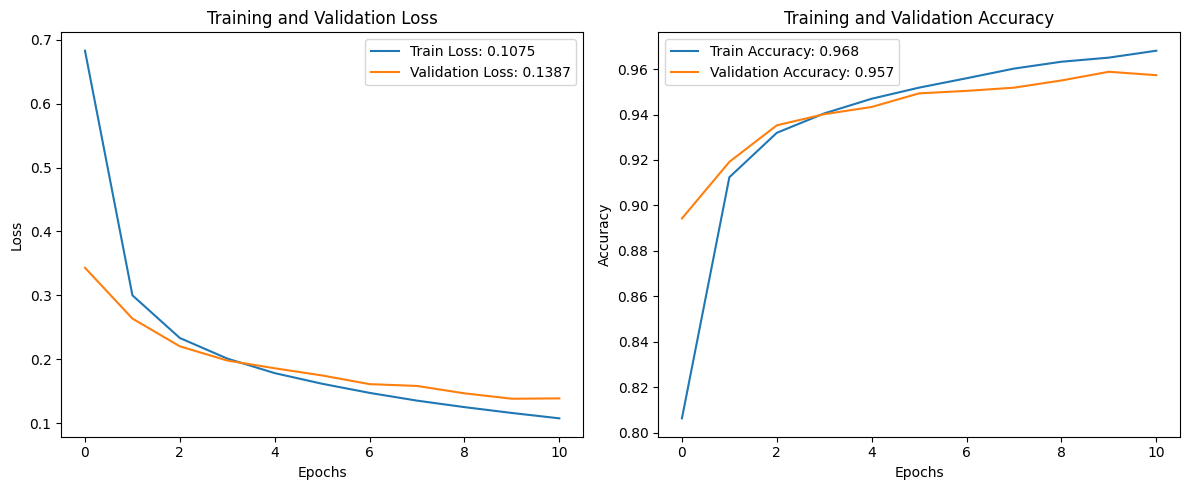

No mejora suficiente en la pérdida de validación por 1 época(s).
Época 12/50 | Train Loss: 0.1002, Train Acc: 0.97% | Val Loss: 0.1348, Val Acc: 0.96%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1348


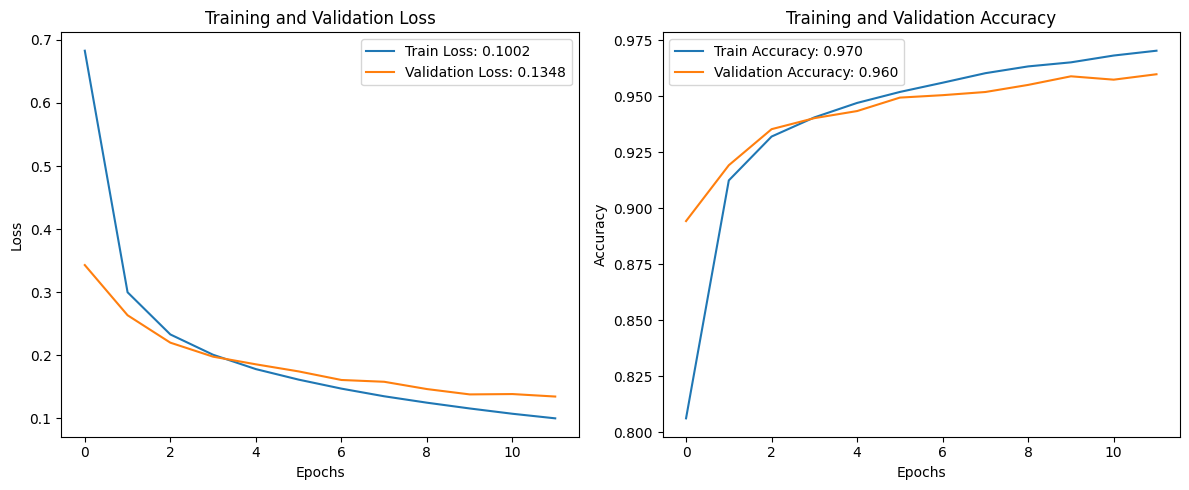

No mejora suficiente en la pérdida de validación por 2 época(s).
Época 13/50 | Train Loss: 0.0948, Train Acc: 0.97% | Val Loss: 0.1346, Val Acc: 0.96%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/best_model.pth con pérdida de validación: 0.1346


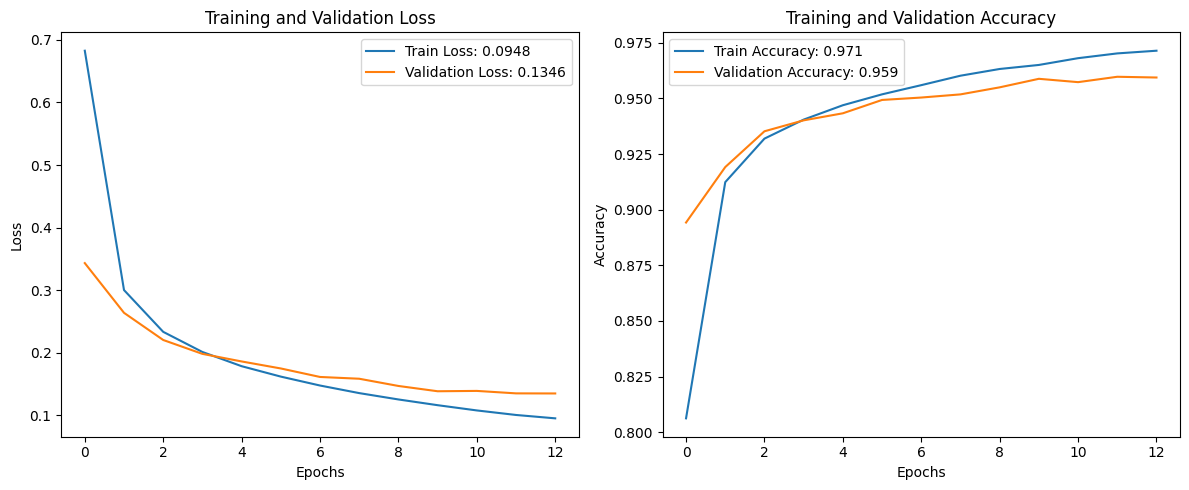

No mejora suficiente en la pérdida de validación por 3 época(s).
Activado Early Stopping: no hay mejora suficiente en la pérdida de validación.


In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print resultados por época
    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- ModelCheckpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Actualiza la mejor pérdida de validación
        torch.save(model.state_dict(), checkpoint_path)  # Guarda el modelo
        print(f"Modelo guardado en {checkpoint_path} con pérdida de validación: {best_val_loss:.4f}")

    # Crear la visualización nuevamente
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    epochs_ = list(range(len(train_loss_history)))

    # Plot 1: Loss
    axes[0].plot(epochs_, train_loss_history, label=f'Train Loss: {train_loss_history[-1]:.4f}', marker='')
    axes[0].plot(epochs_, val_loss_history, label=f'Validation Loss: {val_loss_history[-1]:.4f}', marker='')
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot 2: Accuracy
    axes[1].plot(epochs_, train_acc_history, label=f'Train Accuracy: {train_acc_history[-1]:.3f}', marker='')
    axes[1].plot(epochs_, val_acc_history, label=f'Validation Accuracy: {val_acc_history[-1]:.3f}', marker='')
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # Ajustar el diseño y guardar como PDF
    plt.tight_layout()
    plt.savefig(plot_path + '.pdf', format="pdf")
    plt.show()

    data = f"{epoch},{train_loss},{train_acc},{val_loss},{val_acc}\n"
    with open(csv_path, mode='a') as file:
      file.write(data)

    # --- Early Stopping ---
    if epoch >=1:
      improvement = val_loss_history[-2] - val_loss_history[-1]
      if improvement > min_delta:
          best_val_loss = val_loss  # Actualiza la mejor pérdida de validación
          early_stop_counter = 0  # Reinicia el contador
          print(f"Mejora significativa en pérdida de validación: {improvement:.4f}")
      else:
          early_stop_counter += 1  # Incrementa el contador si no mejora
          print(f"No mejora suficiente en la pérdida de validación por {early_stop_counter} época(s).")

      if early_stop_counter >= patience:
          print("Activado Early Stopping: no hay mejora suficiente en la pérdida de validación.")
          break  # Detiene el entrenamiento

